# 1. IMPORTS AND SETUP

In [28]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from scipy.ndimage import shift
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 2. LOAD AND EXPLORE MNIST DATASET

In [29]:
# Load the MNIST dataset (70,000 images of handwritten digits)

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist['data'], mnist['target']

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Data types: X={type(X)}, y={type(y)}")

Loading MNIST dataset...
Dataset shape: X=(70000, 784), y=(70000,)
Data types: X=<class 'pandas.core.frame.DataFrame'>, y=<class 'pandas.core.series.Series'>


In [30]:
# Convert target labels to integers
y = y.astype(np.uint8)


Sample digit at index 2300:


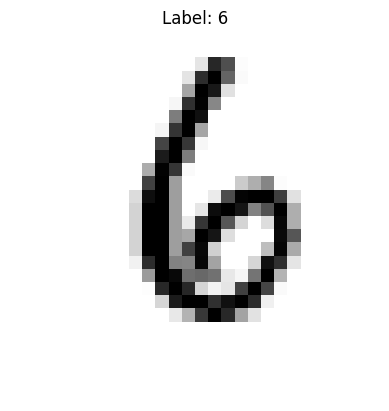

In [45]:
# Visualize a sample digit
def visualize_digit(data, label, index):
    if isinstance(data, pd.DataFrame):
        digit = data.iloc[index].values
    else:
        digit = data[index]
    
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.show()

sample_index = 2300
print(f"\nSample digit at index {sample_index}:")
visualize_digit(X, y.iloc[sample_index] if isinstance(y, pd.Series) else y[sample_index], sample_index)

In [46]:
# Check for missing values
print(f"Missing values in dataset: {X.isnull().any().any()}")

Missing values in dataset: False


# 3. PREPARE TRAINING AND TEST SETS

In [47]:
# Split into training (60,000) and test (10,000) sets
# MNIST convention: first 60k for training, last 10k for testing

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (60000, 784)
Test set: (10000, 784)


In [48]:
# Convert X_train to NumPy array for manipulation
X_train = X_train.values
X_test = X_test.values

# 4. DATA AUGMENTATION - IMAGE SHIFTING

In [49]:
def image_shifter(image, shift_x, shift_y):
    """
    Shift an image by the specified amount in x and y directions.
    
    Args:
        image: 1D array of 784 pixel values
        shift_x: horizontal shift (positive = right, negative = left)
        shift_y: vertical shift (positive = down, negative = up)
    
    Returns:
        Shifted image as 1D array
    """
    image = image.reshape((28, 28))
    shifted_image = shift(image, [shift_y, shift_x], cval=0, mode='constant')
    return shifted_image.reshape([-1])

In [50]:
# Create augmented training dataset by shifting images
# Each original image generates 5 versions: original + 4 shifted versions
print("\nGenerating augmented training data...")

X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    # Original image
    X_train_augmented.append(image)
    y_train_augmented.append(label)
    
    # Shifted up
    X_train_augmented.append(image_shifter(image, 0, -1))
    y_train_augmented.append(label)
    
    # Shifted down
    X_train_augmented.append(image_shifter(image, 0, 1))
    y_train_augmented.append(label)
    
    # Shifted left
    X_train_augmented.append(image_shifter(image, -1, 0))
    y_train_augmented.append(label)
    
    # Shifted right
    X_train_augmented.append(image_shifter(image, 1, 0))
    y_train_augmented.append(label)



Generating augmented training data...


In [51]:
# Convert to NumPy arrays and shuffle
shuffle_indices = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_indices]
y_train_augmented = np.array(y_train_augmented)[shuffle_indices]

print(f"Original training size: {len(X_train)}")
print(f"Augmented training size: {len(X_train_augmented)} (5x expansion)")

Original training size: 60000
Augmented training size: 300000 (5x expansion)


# 5. TRAIN SGD CLASSIFIER

In [52]:
from sklearn.linear_model import SGDClassifier

# Initialize SGD Classifier with appropriate hyperparameters
sgd_clf = SGDClassifier(
    max_iter=20,             # Reduced iterations (default 1000) for faster training
    tol=1e-3,                # Tolerance for stopping criterion
    random_state=42,         # For reproducibility
    n_jobs=-1,               # Use all CPU cores for parallel processing
    early_stopping=True,     # Stop early if validation score doesn't improve
    validation_fraction=0.1, # Use 10% of data for early stopping validation
    n_iter_no_change=3       # Stop if no improvement for 3 iterations
)

# Train the classifier
print("Training started...")
sgd_clf.fit(X_train_augmented, y_train_augmented)

print(f"Training complete! Converged after {sgd_clf.n_iter_} iterations")

Training started...
Training complete! Converged after 8 iterations


# 6. EVALUATE MODEL PERFORMANCE

In [53]:
# Test prediction on sample digit
if isinstance(X, pd.DataFrame):
    sample_digit = X.iloc[sample_index].values
else:
    sample_digit = X[sample_index]
    
prediction = sgd_clf.predict([sample_digit])
print(f"\nSample prediction: {prediction[0]} (actual: {y[sample_index]})")


Sample prediction: 6 (actual: 6)


In [54]:
# Cross-validation on augmented training data
print("\nPerforming cross-validation on augmented training data...")
cv_scores = cross_val_score(sgd_clf, X_train_augmented, y_train_augmented, 
                            cv=3, scoring="accuracy")
print(f"CV Accuracy scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Performing cross-validation on augmented training data...
CV Accuracy scores: [0.81727 0.79848 0.75498]
Mean CV Accuracy: 0.7902 (+/- 0.0261)



Generating confusion matrix...


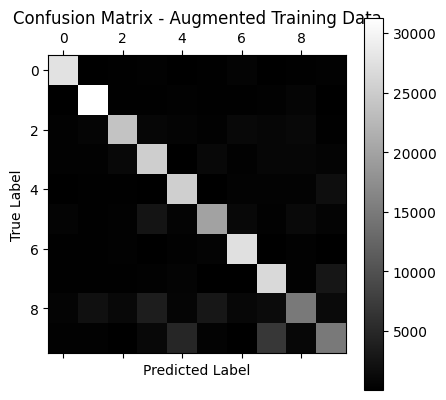

In [55]:
# Generate confusion matrix
print("\nGenerating confusion matrix...")
y_train_pred = cross_val_predict(sgd_clf, X_train_augmented, y_train_augmented, cv=3)
conf_matrix = confusion_matrix(y_train_augmented, y_train_pred)

# Visualize confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.title("Confusion Matrix - Augmented Training Data")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 7. TEST SET EVALUATION

In [56]:
print("\nEvaluating on test set...")

# Evaluate on test data using cross-validation
test_cv_scores = cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring="accuracy")
print(f"Test CV Accuracy scores: {test_cv_scores}")
print(f"Mean Test Accuracy: {test_cv_scores.mean():.4f} (+/- {test_cv_scores.std():.4f})")


Evaluating on test set...
Test CV Accuracy scores: [0.81913617 0.8589859  0.8619862 ]
Mean Test Accuracy: 0.8467 (+/- 0.0195)


# 8. SAVE THE TRAINED MODEL

In [57]:
# Save the trained model to disk
model_filename = 'sgd_clf_multiclass.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(sgd_clf, f)

print(f"\nModel saved to '{model_filename}'")


Model saved to 'sgd_clf_multiclass.pkl'


# 9. LOAD AND TEST SAVED MODEL

In [58]:
# Load the saved model
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)

In [59]:
# Verify it works
if isinstance(X, pd.DataFrame):
    test_sample = X.iloc[sample_index].values
    test_label = y.iloc[sample_index] if isinstance(y, pd.Series) else y[sample_index]
else:
    test_sample = X[sample_index]
    test_label = y[sample_index]

test_prediction = loaded_model.predict([test_sample])
print(f"\nLoaded model prediction: {test_prediction[0]} (actual: {test_label})")
print("Model successfully saved and loaded!")


Loaded model prediction: 6 (actual: 6)
Model successfully saved and loaded!


# SUMMARY

In [60]:
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Dataset: MNIST (70,000 handwritten digits)")
print(f"Original training size: 60,000")
print(f"Augmented training size: 300,000 (5x through shifting)")
print(f"Test set size: 10,000")
print(f"Model: SGDClassifier")
print(f"Augmented data CV accuracy: {cv_scores.mean():.4f}")
print(f"Test set CV accuracy: {test_cv_scores.mean():.4f}")
print(f"Saved model: {model_filename}")
print("="*70)


SUMMARY
Dataset: MNIST (70,000 handwritten digits)
Original training size: 60,000
Augmented training size: 300,000 (5x through shifting)
Test set size: 10,000
Model: SGDClassifier
Augmented data CV accuracy: 0.7902
Test set CV accuracy: 0.8467
Saved model: sgd_clf_multiclass.pkl
